In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import corner
import numpy as np

In [2]:
from torsionfit.toy_model import ToyModel

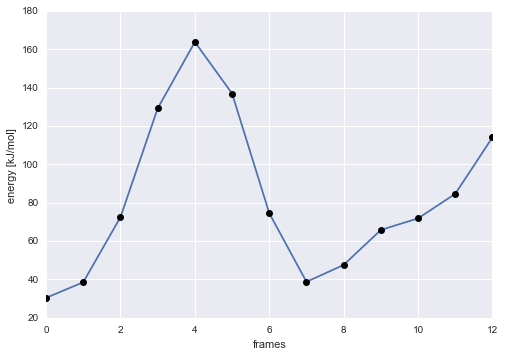

In [7]:
toy = ToyModel()
plt.plot(toy.synthetic_energy)
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')

In [16]:
print(toy.true_value)
print(toy.initial_value)


<DihedralTypes [<DihedralType; phi_k=12.059, per=3, phase=180.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=3.630, per=6, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=4.876, per=4, phase=180.000,  scee=1.000, scnb=1.000>]>
<DihedralTypes [<DihedralType; phi_k=13.656, per=3, phase=180.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.000, per=4, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=4.758, per=6, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.000, per=1, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.000, per=2, phase=0.000,  scee=1.000, scnb=1.000>]>


In [9]:
# sample
sampler = MCMC(toy.model.pymc_parameters)
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 147.6 sec

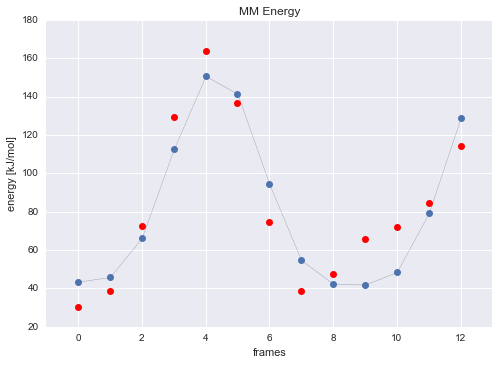

In [10]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, 'o', color='r')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')

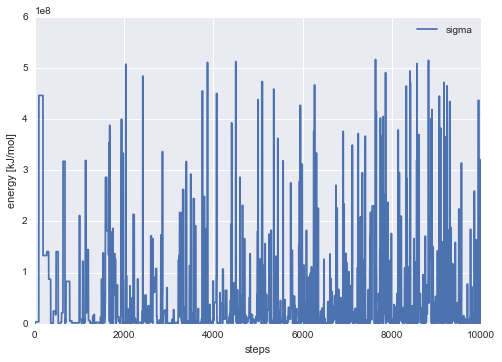

In [11]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')

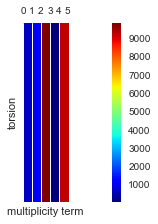

In [13]:
import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 10000, 100, 'random.png')


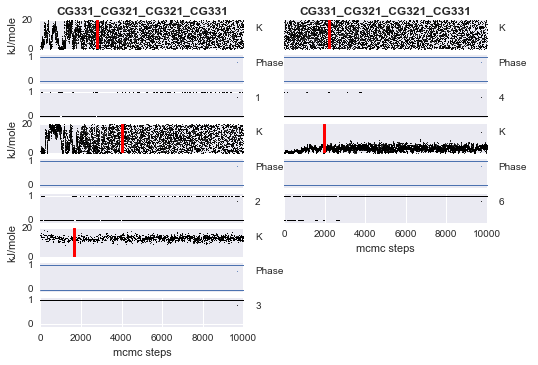

In [14]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0)

In [21]:
data = np.stack((sampler.CG331_CG321_CG321_CG331_1_K.trace[100:],
                sampler.CG331_CG321_CG321_CG331_2_K.trace[100:], sampler.CG331_CG321_CG321_CG331_3_K.trace[100:], 
                sampler.CG331_CG321_CG321_CG331_4_K.trace[100:], sampler.CG331_CG321_CG321_CG331_6_K.trace[100:]), axis=1)

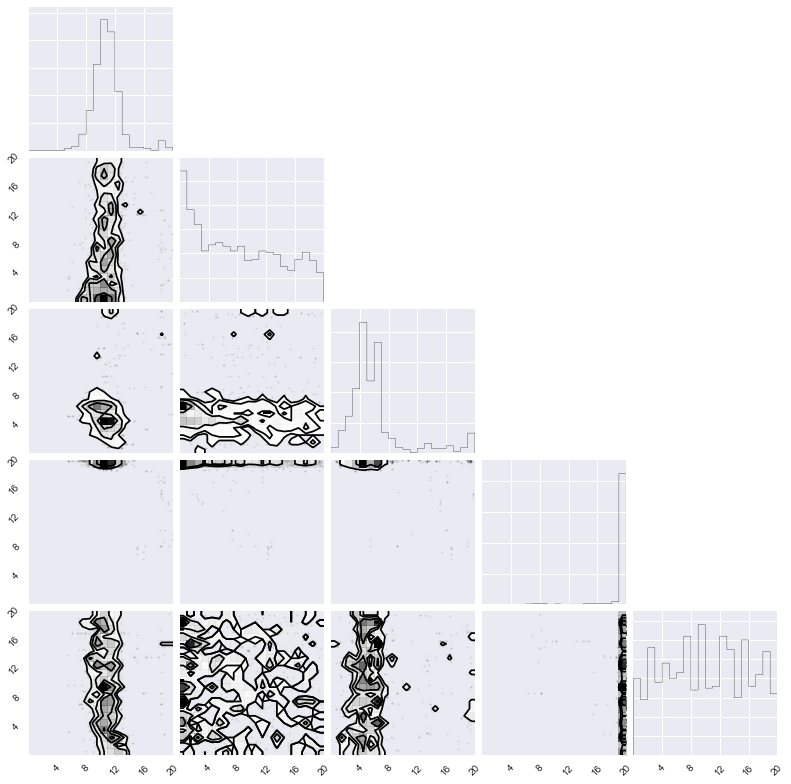

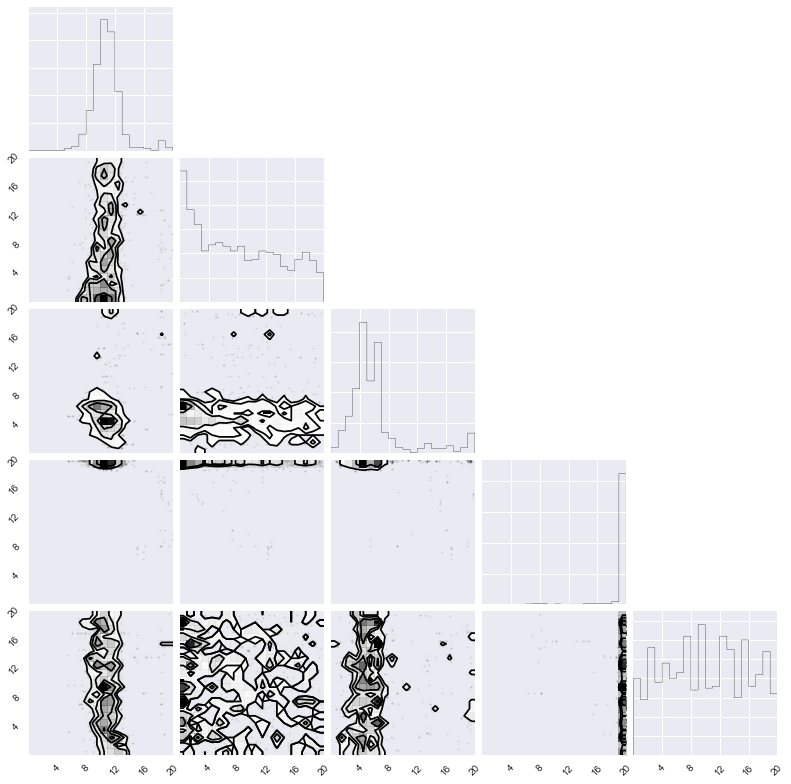

In [22]:
corner.corner(data, plot_countours=False, range=[(0, 20), (0,20), (0,20), (0,20), (0,20)])